<a href="https://colab.research.google.com/github/shashvatshah9/DLCodeDemo/blob/main/DL_Demo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualize and analyse different optimizers in deep learning

### 3 step recipe
- Representation (neural networks)
- Loss Function
- Optimization

### Visualizing different optimizers
- Gradient descent
- Newton's method
- Momentum
- ADAM

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
%matplotlib inline 

f(x, y) = ax^2 + by^2 + cxy + dx + ey

In [6]:
class QuadFunc:
    def __init__(self, a, b, c, d, e):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e
    
    def getParams(self, x, y):
        if y is None:
            y = x[1]
            x = x[0]
        return x, y
    
    def __call__(self, x, y=None):
        x, y = self.getParams(x, y)
        return 0.5*(self.a*x**2 + self.b*y**2 + self.c*x*y + self.d*x + self.e*y)

    def grad(self, x, y=None):
        # df/dx 
        # df/dy

        x, y = self.getParams(x, y)
        return torch.tensor([self.a *x + self.c*y + self.d, self.b*y + self.c*x + self.e])

    def hess(self, x, y=None):
        # d2f/dx2
        # d2f/dy2
        # d2f/ dxdy
        # d2f/ dydx
        x, y = self.getParams(x, y)
        return torch.tensor([[self.a, self.c], [self.c, self.b]])

class GradientDescent:

    def __init__(self,lr=1,b1=0.9,b2=0.999):
        self.lr = lr # learning rate
        self.b1 = b1 # grad aggregation param
        self.b2 = b2 # grad^2 aggregation param
        
        self.v = 0 # grad aggregation
        self.w = 0 # grad^2 aggregation
        self.t = 0
            
        self.eps = 1.0e-9
        
    def __call__(self,grad,hess):
        
        self.t += 1
        
        # aggregation
        self.v = self.b1*(self.v) + (1-self.b1)*grad
        self.w = self.b2*(self.w) + (1-self.b2)*grad**2
        
        # bias correction
        vcorr = self.v/(1-self.b1**self.t)
        wcorr = self.w/(1-self.b2**self.t) if self.b2 != 0 else 1
        
        return -self.lr*vcorr/( wcorr**0.5 + self.eps )


class Newtons:
    # https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization
    def __init__(self,lr=1):
        self.lr = lr
    
    def __call__(self,grad,hess):
        return -self.lr*torch.matmul(torch.inverse(hess),grad)

def runOptim(init,optim,func,steps):
    
    curpos = init # current position
    path = [curpos]

    
    for _ in range(steps):        

        grad = func.grad(curpos)
        hess = func.hess(curpos)
            
        dx = optim(grad,hess)
        curpos = curpos + dx
        path.append(curpos)
    
    return path

def showPath(func,init,paths,labels,colors):

    x = torch.arange(-10,10,0.05)
    y = torch.arange(-10,10,0.05)
    
    # create meshgrid
    xx, yy = torch.meshgrid(x,y)
    zz = func(xx,yy)
    
    # create contour
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    cp = ax.contourf(xx,yy,zz,cmap=cm.gray)
    fig.colorbar(cp)
    
    # mark initial point
    ax.plot(init[0],init[1],'ro')
    ax.text(init[0]+0.5,init[1]+0.5,'Intial Point',color='white')
    
    # Plot paths
    for pnum in range(len(paths)):
        for i in range(len(paths[pnum])-1):
            curpos = paths[pnum][i]
            d = paths[pnum][i+1] - curpos
            ax.arrow(curpos[0],curpos[1],d[0],d[1],color=colors[pnum],head_width=0.2)
            ax.text(curpos[0]+d[0],curpos[1]+d[1],str(i),color='white')
    
    # Add legend
    legends = []
    for col in colors:
        legends.append(mpatches.Patch(color=col))
    ax.legend(legends,labels)
    

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


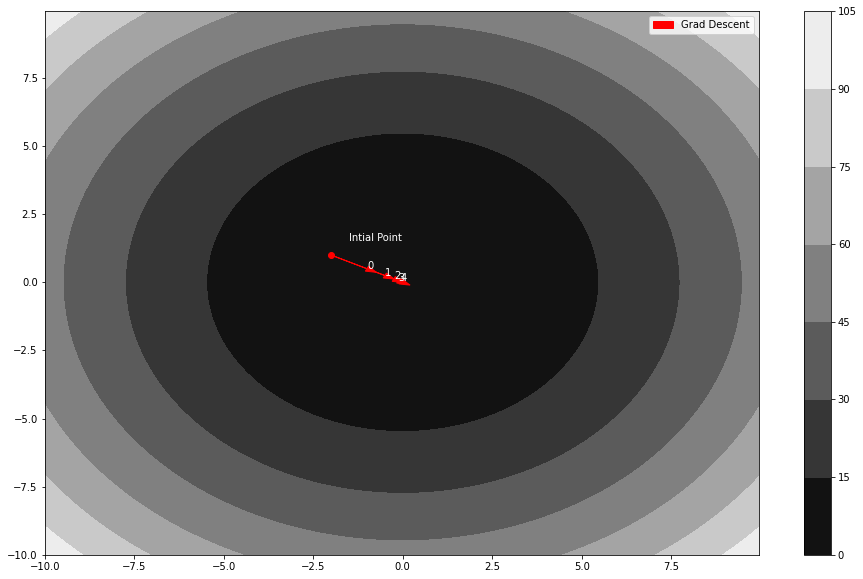

In [9]:
f = QuadFunc(a=1.0, b=1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0, 1.0])
regGd = GradientDescent(lr = 0.5, b1 = 0, b2 = 0) # turned off Momentum and ADAM

steps = 5

path = runOptim(init, regGd, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'])

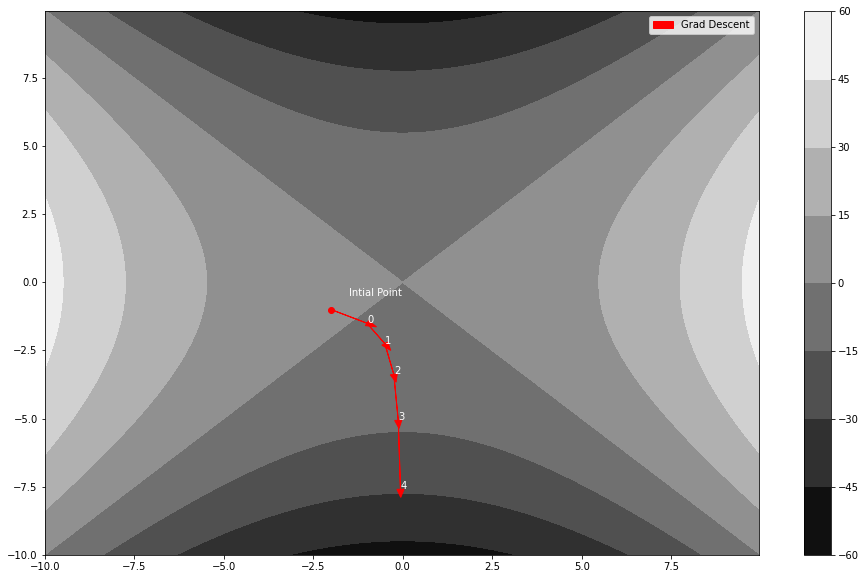

In [11]:
f = QuadFunc(a=1.0, b=-1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0, -1.0])
regGd = GradientDescent(lr = 0.5, b1 = 0, b2 = 0) # turned off Momentum and ADAM

steps = 5

path = runOptim(init, regGd, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'])

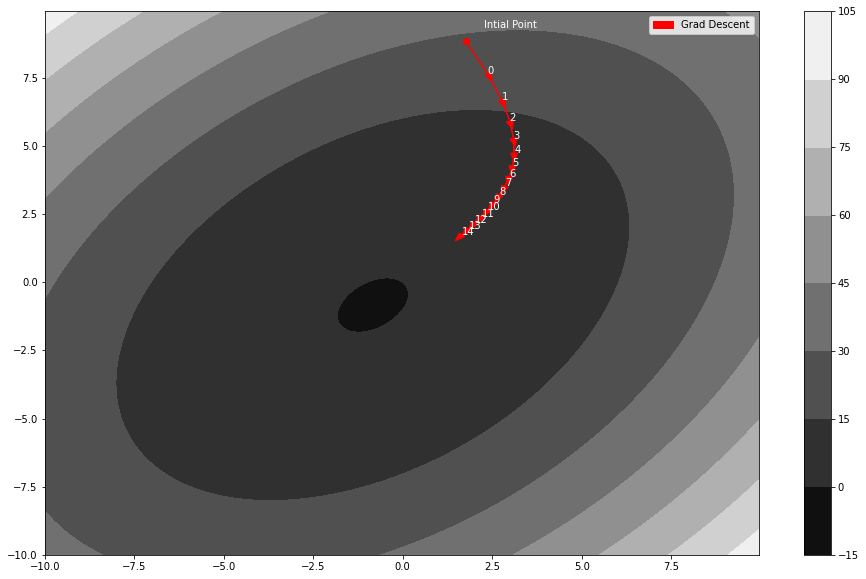

In [14]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a, a], [-a,a]]), torch.tensor([-5.0, 7.5]))
ell = QuadFunc(a,a, -0.8*a, a,a)
steps = 15 
regGd = GradientDescent(lr = 0.2, b1 = 0, b2 = 0) # turned off Momentum and ADAM

path = runOptim(init, regGd, ell, steps)
showPath(ell, init, [path], ['Grad Descent'], ['r'])

- GD depends on initalization
- Follows the steepest direction

## Newton's method

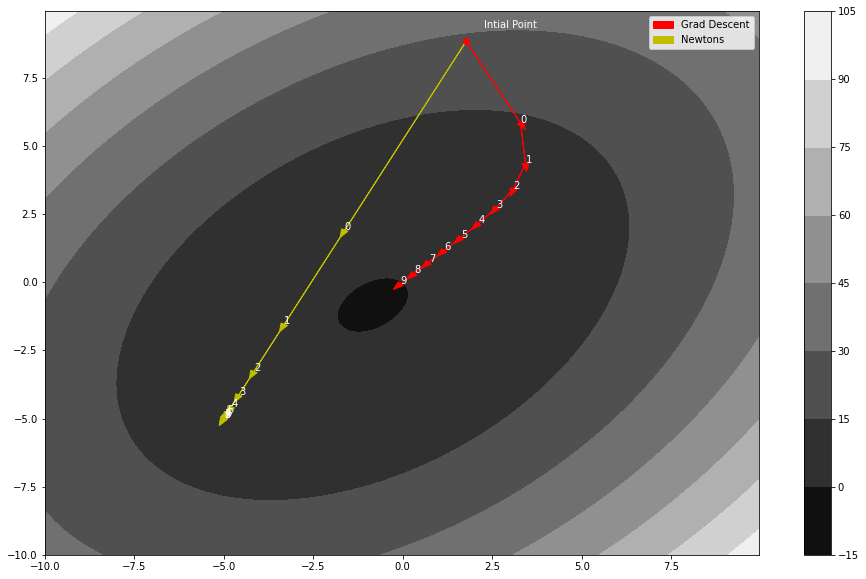

In [16]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a, a], [-a,a]]), torch.tensor([-5.0, 7.5]))
ell = QuadFunc(a,a, -0.8*a, a,a)
steps = 10
lr = 0.5
regGD = GradientDescent(lr,0,0)
newGD = Newtons(lr)
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,newGD,ell,steps)
showPath(ell, init, [path1, path2], ['Grad Descent','Newtons'], ['r', 'y'])

Newton method takeaways
- calculate second order derivative
- attracted to saddle points

# Momentum

we keep a history of gradients and add an additional term

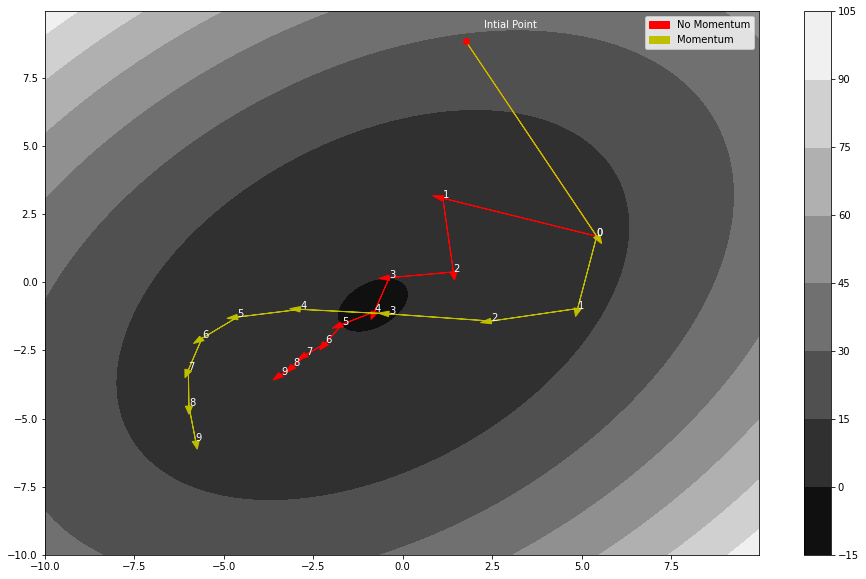

In [18]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a, a], [-a,a]]), torch.tensor([-5.0, 7.5]))
ell = QuadFunc(a,a, -0.8*a, a,a)
steps = 10
lr = 1.2
regGD = GradientDescent(lr,0,0) # without momentum
momGD = GradientDescent(lr,0.9,0) # with momentum
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,momGD,ell,steps)
showPath(ell, init, [path1, path2], ['No Momentum','Momentum'], ['r', 'y'])

# ADAM

automatically tune the learning rate

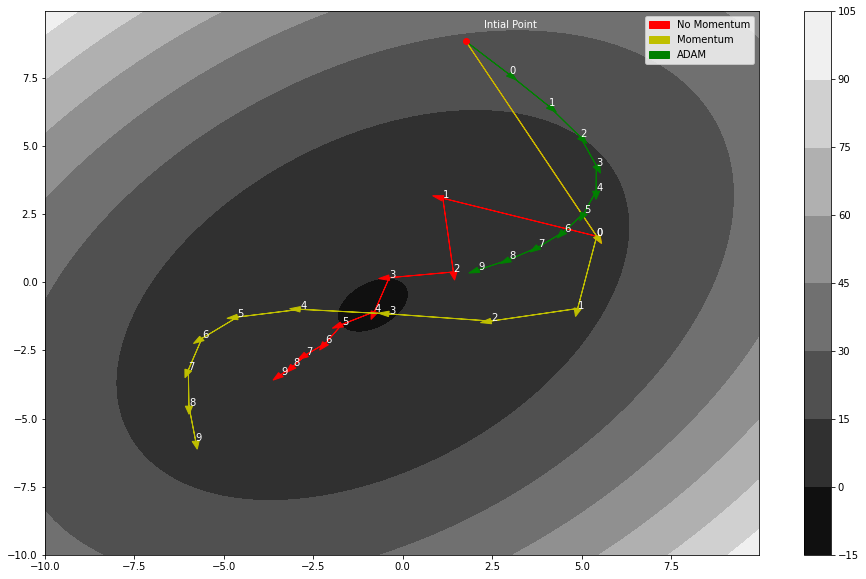

In [19]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a, a], [-a,a]]), torch.tensor([-5.0, 7.5]))
ell = QuadFunc(a,a, -0.8*a, a,a)
steps = 10
lr = 1.2
regGD = GradientDescent(lr,0,0) # without momentum
momGD = GradientDescent(lr,0.9,0) # with momentum
adamGD = GradientDescent(lr,0.9,0.999) # with ADAM

path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,momGD,ell,steps)
path3 = runOptim(init,adamGD,ell, steps)
showPath(ell, init, [path1, path2, path3], ['No Momentum','Momentum', 'ADAM'], ['r', 'y', 'g'])
